In [2]:
# region imports

import os 
os.chdir(r'C:\Users\YbII Cobra\Documents\YbII')


import numpy as np
import matplotlib.pyplot as plt

# Fitting Module
import lmfit
from lmfit.models import gaussian2d

# Image Processing Module
import imageio
import matplotlib.pyplot as plt

from src.functions.math import func as mathf
from src.functions.optics import func as optf
from src.constants import const

directory_path = r'C:\Users\YbII Cobra\Desktop\3D MOT\0703\green_fluo\camera repos'

# endregion

# region functions
# p is the measured power per beam before any VP, w1 and w2 are the beam waist radii
# s0 = 3 * (I_0 * T + I_0 * T ** 3) / I_sat
# def get3DMOTS0(p, w1=2.77e-3, w2=2.64e-3): # before 06/18/24; we now use the newly measured waists 
    # return 3 * p / np.pi / w1 / w2 * (0.955 + 0.955 ** 3) / const.Is_1s0_1p1
def get3DMOTS0(p, w0, wavelength):
    isat = 0
    if wavelength == 'blue':
        isat = const.Isat_1s0_1p1
    elif wavelength == 'green':
        isat = const.Isat_1S0_3P1
    return p / (np.pi * w0 ** 2 / 2) * (0.955 + 0.955 ** 3) / isat


# probability of the atom being in the excited state (from Eva Casotti's thesis)
# f is frequency on the wavemeter
# p is the measured power per beam before any VP
# 3D MOT is 10 MHZ more blue than 2D MOT at the same wavemeter frequency due to AOM freq difference
def rho3DMOT(f, p, wavelength):
    if wavelength == 'blue':
        return get3DMOTS0(p, 3e-3, wavelength) / 2 / (1 + get3DMOTS0(p, 3e-3, wavelength) + (2 * (2 * np.pi * f + (const.omega_aom_399_3DMOT - const.omega_aom_399_2DMOT) - const.w0_1s0_1p1_32) / const.gamma_1s0_1p1) ** 2)
    elif wavelength == 'green':
        return get3DMOTS0(p, 1.8e-3, wavelength) / 2 / (1 + get3DMOTS0(p, 1.8e-3, wavelength) + (2 * 20 ** 2))

# sum up the pixel values in the region of interest
# x0, y0, wx, wy are the parameters of the Gaussian fit
# img_res is the background-subtracted image data
# f is frequency of the cooling beam
# p is the measured power per beam before any VP
# d0 is the image distance from the MOT to the first lens
def get3DMOTAtomNumber(x0, y0, box_x, box_y, img, t_exp, f, p, d0, wavelength, camera):
    
    x0 = int(x0)
    y0 = int(y0)
    wx = int(box_x)
    wy = int(box_y)
    I_sum = np.sum(img[y0-box_y:y0+box_y, x0-box_x:x0+box_x])

    area = (2 * box_x) * (2 * box_y)

    QE = 0
    cap_sat = 0

    QE399_14um = 0.42 # quantum efficiency of acA3800 for 399 nm light
    QE556_14um = 0.37 # quantum efficiency of acA3800 for 556 nm light
    
    QE399_14um = 0.37 # quantum efficiency of the 14uc camera mono mode at 399 nm
    QE399_14uc = 0.17 # quantum efficiency of the 14uc camera RGB mode at 399 nm
    cap_sat_acA3800 = 2800 # saturation capacity of the camera

    #### Flir grasshopper 3 camera
    QE399_flir = 0.45 
    QE556_flir = 0.7 # quantum efficiency of the 14uc camera mono mode at 556 nm
    cap_sat_flir = 10482 # saturation capacity of the camera
    ################################################
    eff = (0.0254/2) ** 2 / (4 * d0 ** 2) # collection efficiency of the imaging setup, assuming using 1 inch lens
    if camera == 'acA3800 14um':
        if wavelength == 'blue':
            QE = QE399_14um  
        elif wavelength == 'green':
            QE = QE556_14um
        cap_sat = cap_sat_acA3800
    elif camera == 'acA3800 14uc':
        raise ValueError('acA3800 14uc parameters not fully implemented')
        # if wavelength == 'blue':
        #     QE = QE399_14uc 
        # elif wavelength == 'green':
            # QE = QE556_14uc
        # cap_sat = cap_sat_acA3800
    elif camera == 'flir':
        if wavelength == 'blue':
            QE = QE399_flir 
        elif wavelength == 'green':
            QE = QE556_flir
        cap_sat = cap_sat_flir
    else: 
        raise ValueError('Camera not recognized')
    ppi = cap_sat / QE / 255 # photon per pixel per intensity
    gamma_tot = I_sum * ppi / eff / t_exp # total photon emission rate
    gamma_atom = const.gamma_1s0_1p1 * rho3DMOT(f, p, wavelength) # photon emission rate of a single atom

    if wavelength == 'green': gamma_atom = 1

    return gamma_tot / gamma_atom


# get the number of imaged atoms
# img is the MOT image data, img_bg is the background image data
# t_exp is the exposure time of the camera
# f is frequency of the cooling beam
# p is the measured power per beam before any VP
def getImaged3DMOTAtomNumber(img, img_bg, t_exp, f, p, d0, background, wavelength, center, camera):
    x_rg = np.arange(0, img.shape[1])
    y_rg = np.arange(0, img.shape[0])

    # keep only the blue channel
    # img = img[:, :, 2]
    if background:
        img_res = np.abs(np.array(img, dtype=float) - np.array(img_bg, dtype=float))
        img_res[img_res < 0] = 0
    else:
        img_res = img

    # img_res[img_res < np.max(img_res) * 0.10] = 0
    x_data = np.max(img_res, axis=0)
    y_data = np.max(img_res, axis=1)


    x0, y0, wx, wy, dwx, dwy, x_fit, y_fit, = 0, 0, 0, 0, 0, 0, 0, 0

    # also in /src/functions/math/func.py
    def GaussianWBaseline(x, center, sigma, amplitude, c_c):
        return amplitude * np.exp(-((x - center) ** 2) / (2 * sigma ** 2)) + c_c

    if wavelength == 'blue':

        model = lmfit.Model(GaussianWBaseline)

        # adjust the initial parameters if needed
        params_x = model.make_params(c_c=0, center=np.argmax(x_data), sigma=50, amplitude=np.max(x_data))
        params_y = model.make_params(c_c=0, center=np.argmax(y_data), sigma=50, amplitude=np.max(y_data))

        # Set constraints if needed
        # params_x['sigma'].set(max=150)
        # params_x['sigma'].set(min=50)
        # params_y['sigma'].set(max=150)
        # params_y['sigma'].set(min=50)
        # params_x['amplitude'].set(min=100)
        # params_y['amplitude'].set(min=100)
        # params_x['center'].set(min=1500)
        # params_x['center'].set(max=2000)
        # params_y['center'].set(min=1500)
        # params_y['center'].set(max=2100)
        params_x['c_c'].set(max=50)
        params_y['c_c'].set(max=50)

        result_x = model.fit(x_data, params_x, x=x_rg)
        result_y = model.fit(y_data, params_y, x=y_rg)

        x_fit = result_x.best_fit
        y_fit = result_y.best_fit


        wx = 2 * result_x.best_values['sigma']
        # dwx = 2 * result_x.params['sigma'].stderr
        dwx = 0

        wy = 2 * result_y.best_values['sigma']
        # dwy = 2 * result_y.params['sigma'].stderr
        dwy = 0

        x0 = result_x.best_values['center']
        y0 = result_y.best_values['center']

    x0 = center[0]
    y0 = center[1]

    # print("2DMOT Diameter:", 4 * 2 * wy * 1.67 * 10**(-3))
    # wx = wx / 2
    # wy = wy / 2
    if not 'flir' in camera:
        box_x=250
        box_y=250
    else: 
        box_x = 121
        box_y = 121

    # for param_name, param in result_x.params.items():
    #     print(f"Parameter: {param_name}, Error: {param.stderr}")
    # #     print(param)


    return img_res, x0, y0, wx, wy, dwx, dwy, x_data, x_fit, y_data, y_fit, box_x, box_y, get3DMOTAtomNumber(x0, y0, box_x, box_y, img_res, t_exp, f, p, d0, wavelength, camera)

# plot the image data along with the Gaussian fit and the atom number
# img is the MOT image data, img_bg is the background image data
# t_exp is the exposure time of the camera
# f is the laser frequency in angular frequency units
# p is the measured power per beam before any VP
def plot3DMOTNumber(img, img_bg, t_exp, p, f=751.5270397e12, d0=195e-3, background=False, m=1/4, wavelength='b',center=[1400, 2000], save=True, plot=True, filename='filename', camera='acA3800 14um'):
    
    # m = 1/4
    pixel_to_mm = 1.67 * 10**(-3)

    x_rg = np.arange(0, img.shape[1])
    y_rg = np.arange(0, img.shape[0])

    img_res, x0, y0, wx, wy, dwx, dwy, x_data, x_fit, y_data, y_fit, box_x, box_y, atom_num = getImaged3DMOTAtomNumber(img, img_bg, t_exp, f, p, d0, background, wavelength, center, camera)
    if plot: 
        fig, axs = plt.subplots(1, 2, figsize=(10, 6))
        
        v_max = 255
        if wavelength == 'green':
            v_max = 150

        axs[0].imshow(img_res, origin='lower', vmin=0, vmax=v_max)

        axs[0].set_xlim([0, img.shape[1]])
        axs[0].set_ylim([0, img.shape[0]])
        axs[0].set_xlabel('Pixel')
        axs[0].set_ylabel('Pixel')

        axs[0].hlines(y0, x0-box_x, x0+box_x, color='b', linestyles='dotted', linewidth=0.75)
        axs[0].hlines(y0-box_y, x0-box_x, x0+box_x, color='b', linestyles='dotted', linewidth=0.75)
        axs[0].hlines(y0+box_y, x0-box_x, x0+box_x, color='b', linestyles='dotted', linewidth=0.75)
        axs[0].vlines(x0, y0-box_y, y0+box_y, color='r', linestyles='dotted', linewidth=0.75)
        axs[0].vlines(x0-box_x, y0-box_y, y0+box_y, color='r', linestyles='dotted', linewidth=0.75)
        axs[0].vlines(x0+box_x, y0-box_y, y0+box_y, color='r', linestyles='dotted', linewidth=0.75)

        axs[1].scatter(x_rg, x_data)
        # axs[1].plot(x_rg, x_fit, 'r', label='x Fit')
        axs[1].scatter(y_rg, y_data)
        # axs[1].plot(y_rg, y_fit, 'b', label='y Fit')
        axs[1].vlines(x0-box_x, 0, 100, color='r', linestyles='dotted', linewidth=1, label='x bounds')
        axs[1].vlines(x0+box_x, 0, 100, color='r', linestyles='dotted', linewidth=1)
        axs[1].vlines(y0-box_y, 0, 100, color='b', linestyles='dotted', linewidth=1, label='y bounds')
        axs[1].vlines(y0+box_y, 0, 100, color='b', linestyles='dotted', linewidth=1)
        
        # axs[1].set_ylim([0, 130])
        axs[1].set_xlabel('Pixel')
        axs[1].set_ylabel('Intensity')
        # axs[1].set_ylim([0, 150])

        axs[1].legend()

        factor = 100
        if wavelength == 'blue':
            fig.suptitle('3D MOT #Atom ~ {:.1e}'.format(atom_num) + 
                        '\n Center position: ({}, {}); Box size: ({}, {})'.format(int(x0), int(y0), box_x * 2, box_y * 2) + 
                        '\n Fitted waists: (wx={}({}) mm,  wy={}({}) mm)'.format(round(wx / m * pixel_to_mm, 2),int(round(dwx * factor / m * pixel_to_mm, 0)),round(wy / m * pixel_to_mm, 2), int(round(dwy * factor / m * pixel_to_mm, 0))))
        elif wavelength == 'green':
            # fig.suptitle(r'$\tilde{{N}}^{{556}}=$(Green CPS) / $(\Gamma_{{0}}^{{556}} / 2)$ = {:.1e}'.format(atom_num) + 
            #              '\n' + filename + ', t_exp='+str(t_exp) + ' s')
            fig.suptitle(r'$R_{{tot}}^{{556}}=J_{{sum}}/t_{{exp}}$ = {:.1e}/s'.format(atom_num) + 
                         '\n' + filename + ', t_exp='+str(t_exp) + ' s')
        if save:
            plt.savefig(os.path.join(directory_path, filename+'.png'))
        # plt.show()
        # plt.close()
    return atom_num

# endregion

634702.156348985

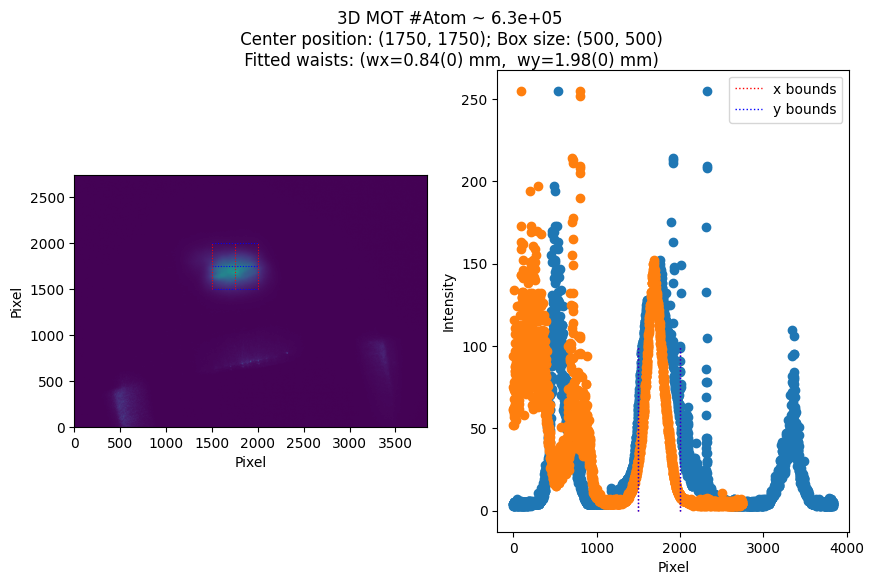

In [5]:
file_path = r'C:\Users\YbII Cobra\Desktop\3D MOT\0731/'
file_name = r't_11900_0_us.bmp'

# file_path_bg = r'C:\Users\YbII Cobra\Desktop\3D MOT\0710\green\turning off blue\PV=7.2mW'

P_green = 19.9e-3
P_blue = 59.3e-3

background = 0

file_path_bg = file_path
# file_path_bg = r'\Basler_acA3800-14um__24872332__20240716_173302385_0000.bmp'

if background:
    file_name_bg = file_name[:-4] + '_bg.bmp'
else:
    file_name_bg = file_name
    # file_name_bg = file_name[:-4] + '_bg.bmp'

plot3DMOTNumber(imageio.v2.imread(file_path + file_name), 
                imageio.v2.imread(file_path + file_name_bg), 
                t_exp = 11900e-6, 
                p = P_blue, 
                background=background, 
                wavelength='blue', 
                save=False, 
                filename='94.875 MHz',
                center = [1750,1750],
                plot=True, 
                f=751.5270397e12 + 5e6, 
                d0 = 195e-3,
                camera='acA3800 14um',
    )


2627346664.1420236

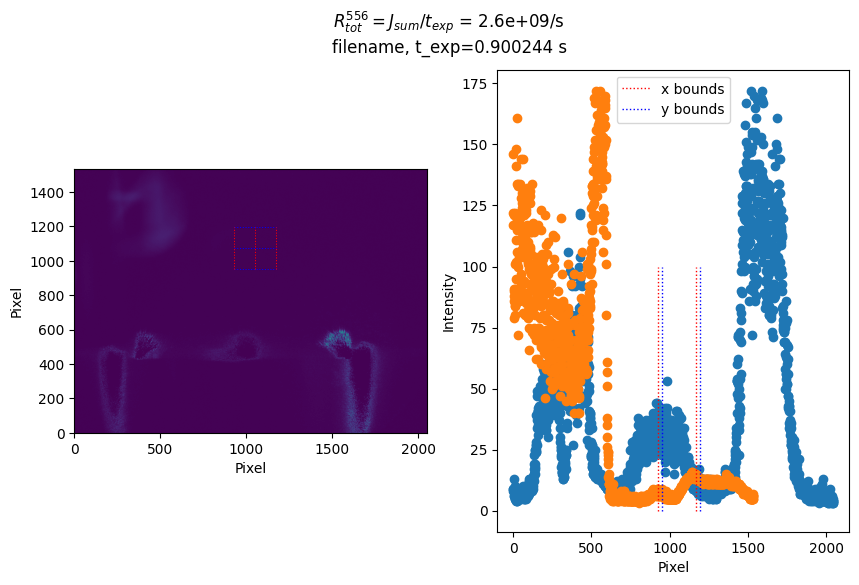

In [12]:
file_path = r'C:\Users\YbII Cobra\Desktop\3D MOT\0731\green\flir\H2ax/'
file_name = r't_900244_77_us_theta_-90_0_deg.bmp'
# file_path_bg = r'C:\Users\YbII Cobra\Desktop\3D MOT\0710\green\turning off blue\PV=7.2mW'
background = 1
bg_box = [1500,800]
green_box = [1050,1075]
blue_box = [1700, 1750]

file_path_bg = file_path
# file_path_bg = r'\Basler_acA3800-14um__24872332__20240716_173302385_0000.bmp'
if background:
    file_name_bg = file_name[:-4] + '_bg.bmp'
else:
    file_name_bg = file_name
    # file_name_bg = file_name[:-4] + '_bg.bmp'
# print(file_path + file_name)
# print(file_path + file_path_bg)
plot3DMOTNumber(imageio.v2.imread(file_path + file_name), 
                imageio.v2.imread(file_path + file_name_bg), 
                t_exp = 900244e-6, 
                p = 60e-3, 
                background=background, 
                wavelength='green', 
                center = green_box,
                save=False,  
                f=751.5270397e12+2.5e6,
                camera='flir',
                )
